# New York City Airbnb Ratings

### Motivation
As the world is getting back to travelling, a major concern for tourists is where they will be staying. While tourism sites offer listings for hotels as credible and accomodations, it is often outside the budget or personal preferences of many, from solo travellers to families. 

This project will explore the airbnb listings for New York City, which is one of the most popular locations for Airbnb listings. Using the [open data from Inside Airbnb](http://insideairbnb.com/get-the-data), this project aims to deliver some insight for predicting the popularity of a listing (our target variable is number of reviews per month). Airbnb and listers can use this analysis to predict how popular future listings might be, and use this to create more appealing listings or improve poorly performing listings.

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel



#to make the interactive maps
import folium
from folium.plugins import FastMarkerCluster
import geopandas as gpd
from branca.colormap import LinearColormap

# Initial Data Inspection

Documentation for what each feature represents is available in the [Inside Airbnb Data Dictionary](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit#gid=982310896).

In [2]:
# reading the data
nyc_df = pd.read_csv("data/listings.csv")
nyc_df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,21935608,https://www.airbnb.com/rooms/21935608,20240105143223,2024-01-05,previous scrape,Rental unit in New York · ★4.67 · 1 bedroom · ...,NaN,NaN,https://a0.muscache.com/pictures/55c47994-3f02...,5448955,...,4.8,5.0,4.4,NaN,f,1,1,0,0,0.20
1,743430766348459803,https://www.airbnb.com/rooms/743430766348459803,20240105143223,2024-01-05,previous scrape,Rental unit in Brooklyn · 1 bedroom · 1 bed · ...,NaN,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,83422715,...,NaN,NaN,NaN,NaN,t,1,1,0,0,NaN
2,4539906,https://www.airbnb.com/rooms/4539906,20240105143223,2024-01-06,previous scrape,Rental unit in New York · 1 bedroom · 1 bed · ...,NaN,NaN,https://a0.muscache.com/pictures/d20c2690-17a3...,23540800,...,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN
3,22122723,https://www.airbnb.com/rooms/22122723,20240105143223,2024-01-05,previous scrape,Rental unit in New York · 1 bedroom · 1 bed · ...,NaN,NaN,https://a0.muscache.com/pictures/6a943c46-cb6c...,43719554,...,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN
4,22434861,https://www.airbnb.com/rooms/22434861,20240105143223,2024-01-05,previous scrape,Rental unit in Brooklyn · 3 bedrooms · 4 beds ...,NaN,NaN,https://a0.muscache.com/pictures/3b4347a6-3300...,5925222,...,5.0,5.0,5.0,NaN,f,1,1,0,0,0.01


### Cleaning up the data

After manual inspection of the dataset, the columns to be dropped were determined under the following guidelines:
* no personal information about the host (such as host neighbourhood, host about, host's profile picture, etc.)
* repetitive data
    * for example, there is neighbourhoods and neighbourhood_cleansed columns. Where applicable the 'cleaned' column was kept.
    * for example, there are several time frames for number of reviews, the number of reviews per year column is kept. 


In [3]:
# removing the irrelevant columns

drop_columns = ['listing_url', 'description', 'scrape_id', 'last_scraped', 'source', 'picture_url', 'host_name', 'host_since', 
                      'host_location', 'host_about', 'host_listings_count', 'host_url', 'host_response_time', 'host_response_rate', 'host_thumbnail_url', 
                      'host_picture_url', 'host_neighbourhood', 'host_verifications', 'host_has_profile_pic', 
                      'host_identity_verified', 'neighbourhood', 'bathrooms', 'bedrooms', 'amenities', 'minimum_minimum_nights',
                      'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
                      'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 
                      'calendar_last_scraped', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 
                      'last_review', 'license', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
                      'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'
                     ]
nyc_df_cleaned = nyc_df.drop(columns=drop_columns)

nyc_df_cleaned.head()


,id,name,neighborhood_overview,host_id,host_acceptance_rate,host_is_superhost,host_total_listings_count,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month
0,21935608,Rental unit in New York · ★4.67 · 1 bedroom · ...,NaN,5448955,NaN,f,3.0,East Village,Manhattan,40.73179,...,15,4.67,4.87,4.8,5.0,4.8,5.0,4.4,f,0.20
1,743430766348459803,Rental unit in Brooklyn · 1 bedroom · 1 bed · ...,NaN,83422715,100%,f,2.0,Flatbush,Brooklyn,40.65375,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,NaN
2,4539906,Rental unit in New York · 1 bedroom · 1 bed · ...,NaN,23540800,NaN,f,1.0,Hell's Kitchen,Manhattan,40.75378,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN
3,22122723,Rental unit in New York · 1 bedroom · 1 bed · ...,NaN,43719554,NaN,f,2.0,Harlem,Manhattan,40.82440,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN
4,22434861,Rental unit in Brooklyn · 3 bedrooms · 4 beds ...,NaN,5925222,NaN,f,5.0,Bushwick,Brooklyn,40.69020,...,1,5.00,5.00,5.0,5.0,5.0,5.0,5.0,f,0.01


# Data Splitting

This project will be splitting the data into a 70% train and 30% test proportion, with random_state=123 for reproducibility. All data exploration and any training will be conducted *only* on the train set to avoid exposure and bias to the test set. This way, we will also get a better sense of the generalizability of our trained model and how well it is able to perform on unseen data.

In [4]:
train_df, test_df = train_test_split(nyc_df_cleaned, test_size=0.3, random_state=123)

train_df.head()

,id,name,neighborhood_overview,host_id,host_acceptance_rate,host_is_superhost,host_total_listings_count,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month
7481,766662217155646157,Hotel in New York · 1 bedroom · 2 beds · 1 bath,Grand Central Terminal - 0.1 miles; <br />Brya...,174792040,98%,f,8875.0,Murray Hill,Manhattan,40.75067,...,1,5.00,5.0,5.00,5.0,5.00,5.00,5.00,t,0.15
13704,1060239215738679244,Rental unit in New York · ★New · Studio · 1 be...,"Located on a tranquil, tree-lined block, half ...",35491667,91%,f,22.0,Upper West Side,Manhattan,40.79260,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN
37758,595656476182329187,Rental unit in Bronx · ★4.89 · 1 bedroom · 1 b...,NaN,357452194,83%,f,3.0,Claremont Village,Bronx,40.84057,...,9,4.89,5.0,4.78,5.0,5.00,4.78,4.89,f,0.56
38153,963371797604061344,Rental unit in Brooklyn · 2 bedrooms · 2 beds ...,- 15-20 mini from JFK airport <br />- L train...,305089539,67%,f,1.0,Canarsie,Brooklyn,40.63804,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN
39473,24540842,Serviced apartment in New York · ★5.0 · Studio...,NaN,6524762,70%,t,89.0,Midtown,Manhattan,40.76527,...,28,5.00,5.0,5.00,5.0,4.96,5.00,4.86,f,0.40


# Exploratory Data Analysis

In [5]:
# obtaining a summary of the dataset

nyc_summary = train_df.describe(include = 'all')
nyc_summary

,id,name,neighborhood_overview,host_id,host_acceptance_rate,host_is_superhost,host_total_listings_count,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month
count,2.780300e+04,27803,15979,2.780300e+04,18880,27683,27798.000000,27803,27803,27803.000000,...,27803.000000,19703.000000,19695.000000,19702.000000,19692.000000,19700.000000,19689.000000,19690.000000,27803,19698.000000
unique,NaN,9347,12158,NaN,99,2,NaN,221,5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN
top,NaN,Rental unit in New York · 1 bedroom · 1 bed · ...,Times Square - 0.1 miles; <br />Broadway - 0.1...,NaN,100%,f,NaN,Bedford-Stuyvesant,Manhattan,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN
freq,NaN,1454,69,NaN,5027,21399,NaN,1987,12173,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22253,NaN
mean,3.165540e+17,NaN,NaN,1.614119e+08,NaN,NaN,244.733938,NaN,NaN,40.729104,...,25.170953,4.693793,4.739565,4.623887,4.810753,4.805904,4.726593,4.619109,NaN,0.990812
std,4.116422e+17,NaN,NaN,1.728788e+08,NaN,NaN,1051.715353,NaN,NaN,0.056227,...,58.115499,0.497932,0.483438,0.559404,0.424084,0.450970,0.416593,0.525392,NaN,1.760970
min,2.595000e+03,NaN,NaN,2.234000e+03,NaN,NaN,1.000000,NaN,NaN,40.500314,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.010000
25%,2.018151e+07,NaN,NaN,1.696535e+07,NaN,NaN,1.000000,NaN,NaN,40.688889,...,0.000000,4.620000,4.690000,4.500000,4.800000,4.800000,4.630000,4.500000,NaN,0.110000
50%,4.677945e+07,NaN,NaN,8.171215e+07,NaN,NaN,3.000000,NaN,NaN,40.726230,...,4.000000,4.830000,4.890000,4.800000,4.940000,4.960000,4.840000,4.750000,NaN,0.370000
75%,7.666268e+17,NaN,NaN,2.901771e+08,NaN,NaN,12.000000,NaN,NaN,40.762410,...,22.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.930000,NaN,1.350000


In [6]:
# obtaining the type of data for each feature

print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 27803 entries, 7481 to 15725
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            27803 non-null  int64  
 1   name                          27803 non-null  object 
 2   neighborhood_overview         15979 non-null  object 
 3   host_id                       27803 non-null  int64  
 4   host_acceptance_rate          18880 non-null  object 
 5   host_is_superhost             27683 non-null  object 
 6   host_total_listings_count     27798 non-null  float64
 7   neighbourhood_cleansed        27803 non-null  object 
 8   neighbourhood_group_cleansed  27803 non-null  object 
 9   latitude                      27803 non-null  float64
 10  longitude                     27803 non-null  float64
 11  property_type                 27803 non-null  object 
 12  room_type                     27803 non-null  object 
 13  acc

In [7]:
# price is set as an object right now because of the '$' before each value. 
# Removing $ so the dtype is changed from object to float. 

train_df['price'] = train_df['price'].str.replace('[\$,]', '', regex=True).astype(float)

In [8]:
# bathrooms_text is set as an object because it is formated as '[number] bath'. 
# converting column so that only the number is kept for the bathrooms column

def extract_no(text):
    if pd.isna(text):
        return None
    match = re.search(r'\d+\.?\d*', text)
    return float(match.group()) if match else None

# Applying the function to the 'bathrooms_text' column
train_df['bathrooms'] = train_df['bathrooms_text'].apply(extract_no)

train_df.drop('bathrooms_text', axis=1, inplace=True)

train_df['bathrooms'].head()

7481     1.0
13704    1.0
37758    1.0
38153    1.0
39473    1.0
Name: bathrooms, dtype: float64

In [9]:
# host_acceptance_rate is set as an object because it is formatted as 'number%'.
# converting column to remove '%' so that the column is of data type int

train_df['host_acceptance_rate'] = train_df['host_acceptance_rate'].str.replace('%', '').astype(float).fillna(0).astype(int)

train_df['host_acceptance_rate'].head()

7481     98
13704    91
37758    83
38153    67
39473    70
Name: host_acceptance_rate, dtype: int32

In [10]:
# exploring some potentially useful values

# most frequently occurring neigbourhood_group
most_feq_neighbourhood_group = train_df["neighbourhood_group_cleansed"].astype(str).mode().values[0]
print("most popular neighbourhood group: " + most_feq_neighbourhood_group)

# least frequently occurring neighbourhood_group
least_frequent_value = train_df['neighbourhood_group_cleansed'].value_counts().idxmin()
print("least popular neighbourhood group: " +least_frequent_value)

# most frequently occurring property types
most_feq_property_type = train_df["property_type"].astype(str).mode().values[0]
print("most popular property type: " + most_feq_property_type)

# most frequently occurring room_types
most_feq_room_type = train_df["room_type"].astype(str).mode().values[0]
print("most popular room type: " + most_feq_room_type)

# columns with missing values
missing_vals_cols = train_df.columns[train_df.isna().any()].tolist()
print("features with missing values: " + str(missing_vals_cols))

most popular neighbourhood group: Manhattan
least popular neighbourhood group: Staten Island
most popular property type: Entire rental unit
most popular room type: Entire home/apt
features with missing values: ['neighborhood_overview', 'host_is_superhost', 'host_total_listings_count', 'beds', 'price', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month', 'bathrooms']


## Visualizing features

### Numerical Variables

The mean number of reviews is 25.170953, which is rounded downto 25 for this exploration. Below is the visualization of features that get above and below the average number of reviews.

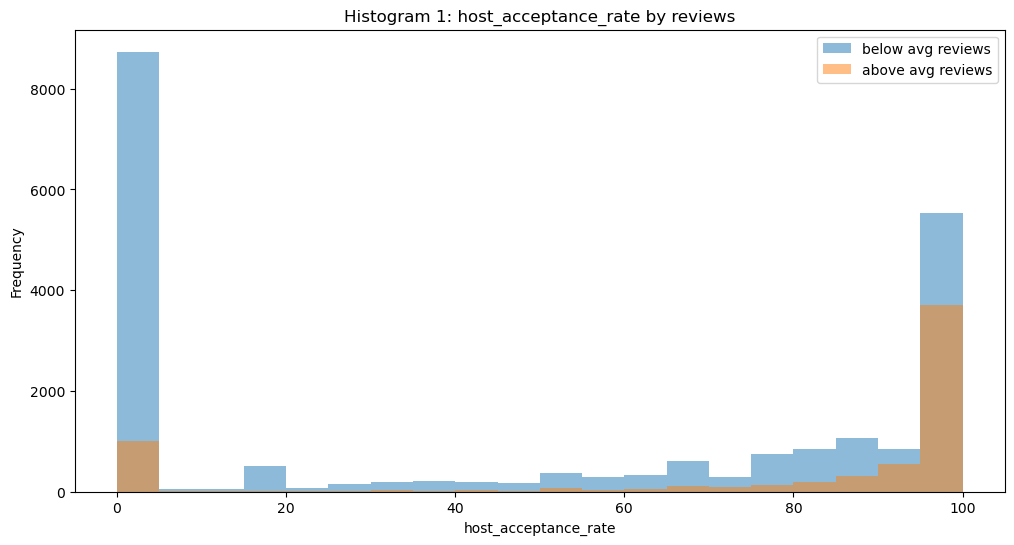

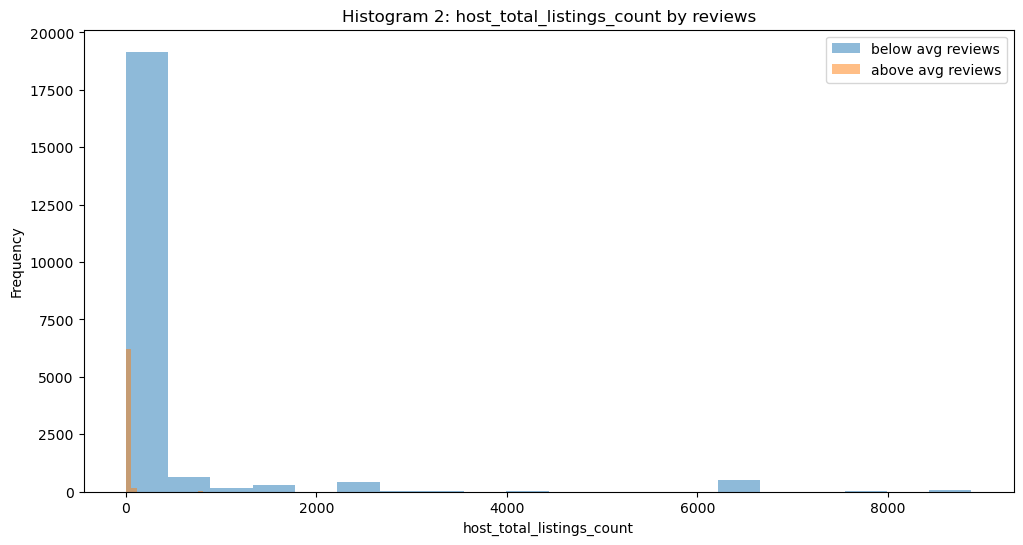

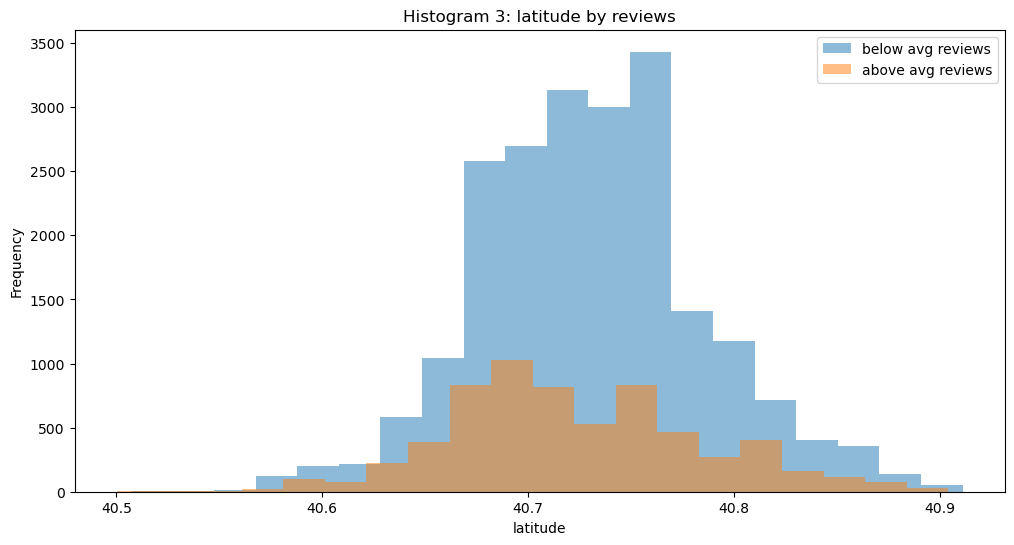

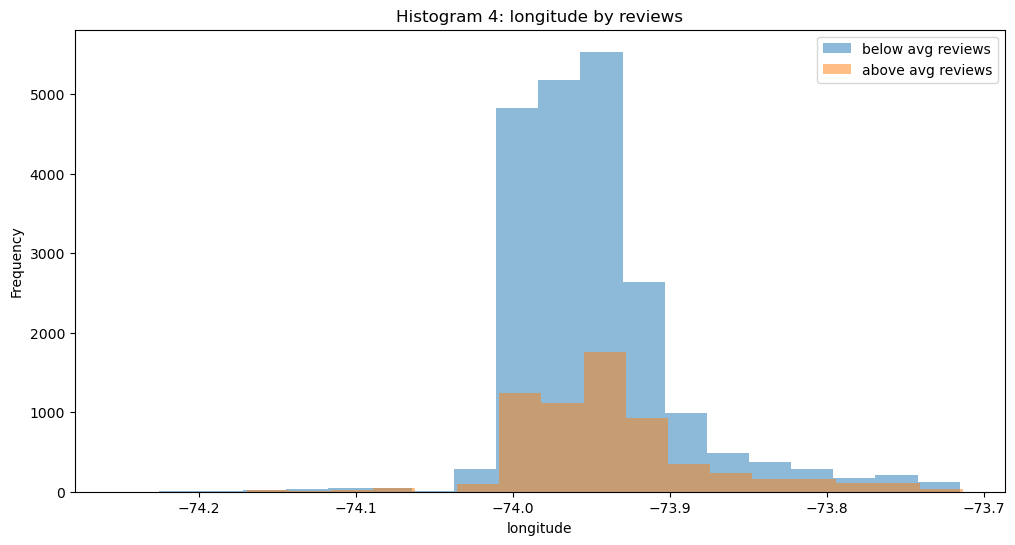

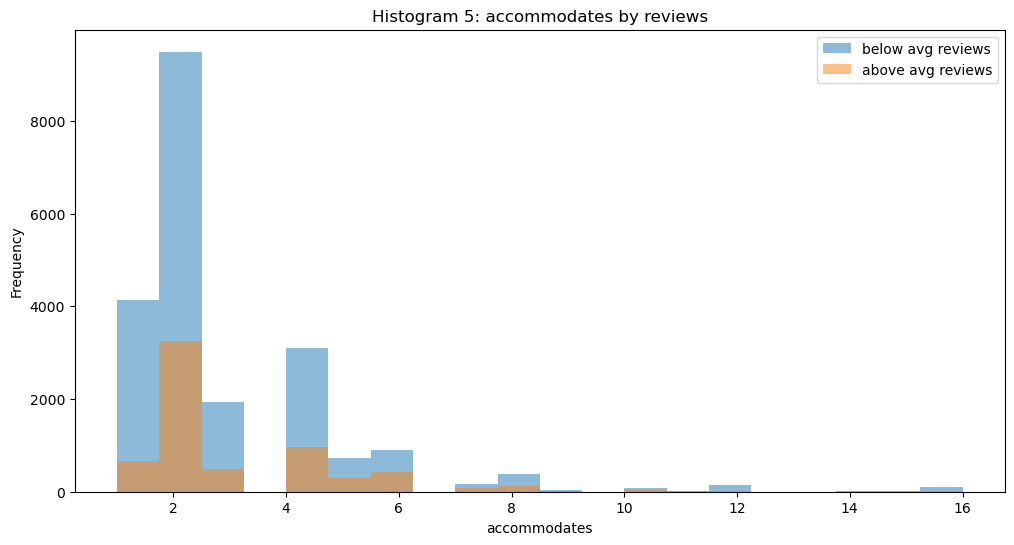

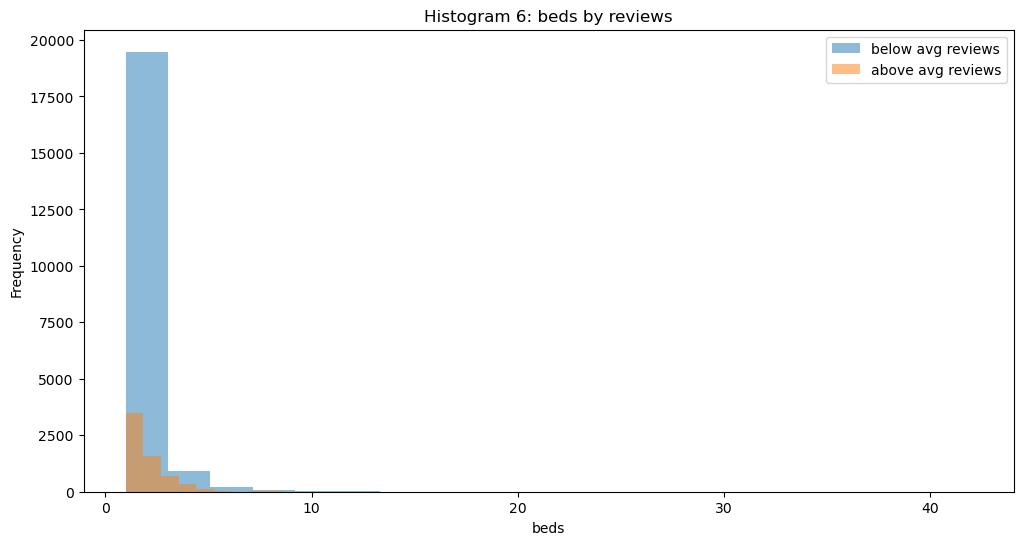

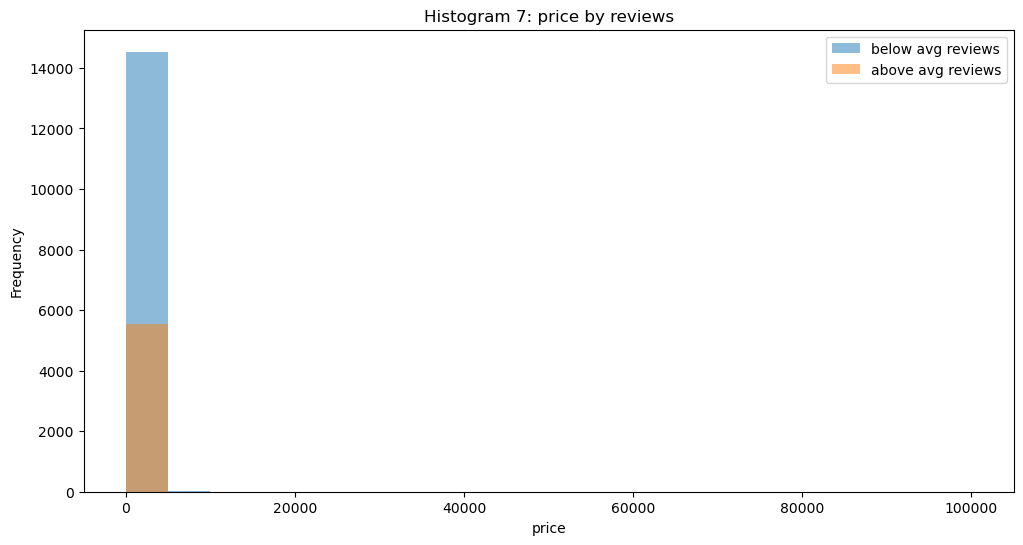

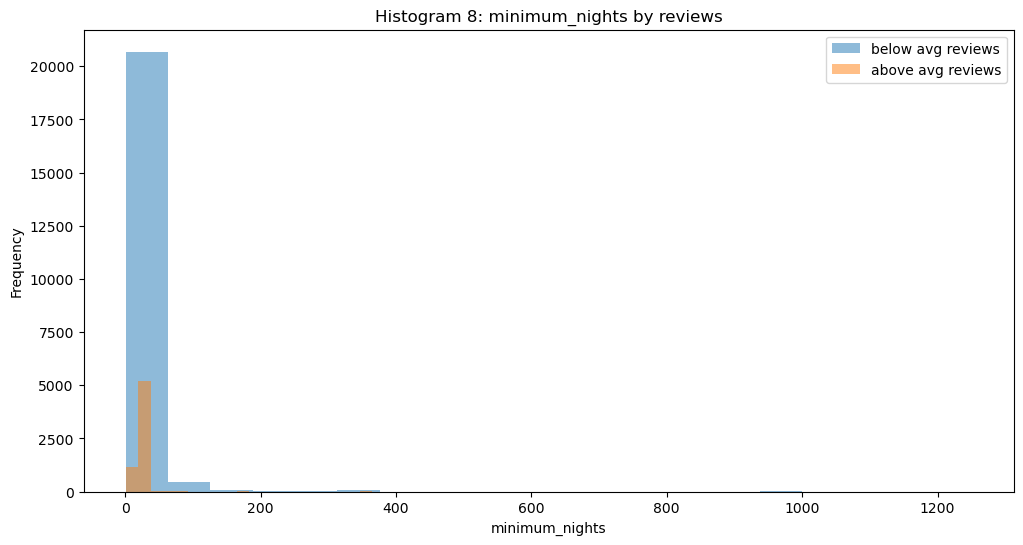

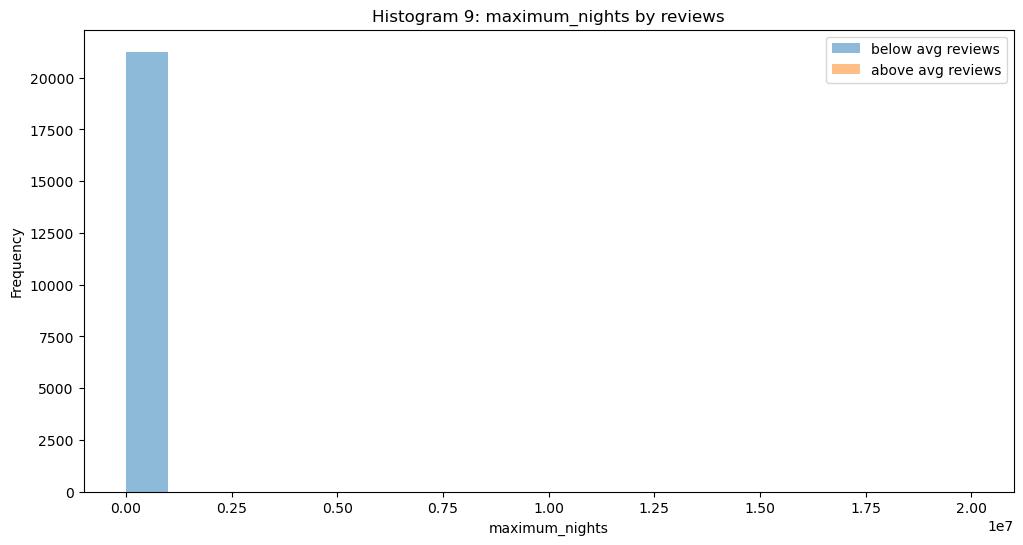

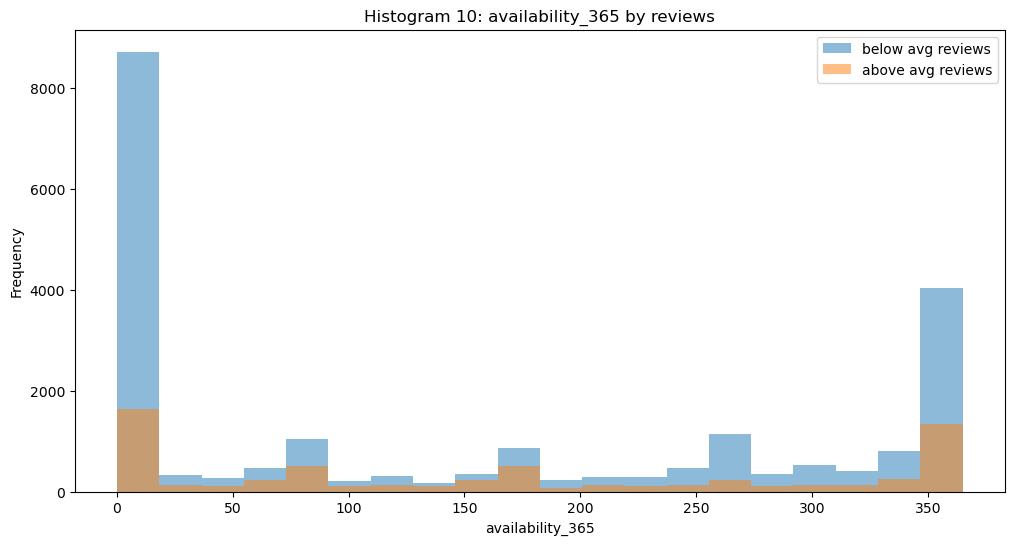

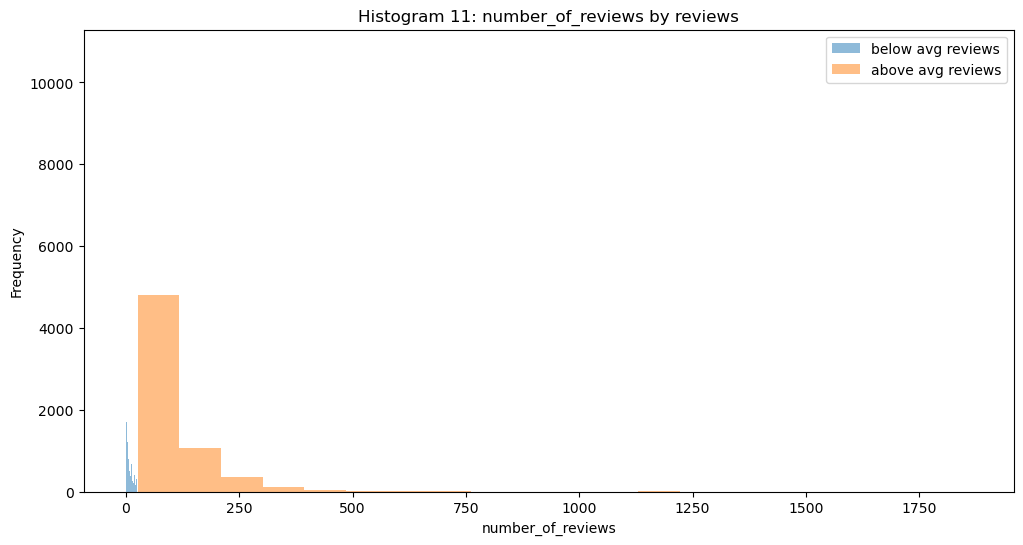

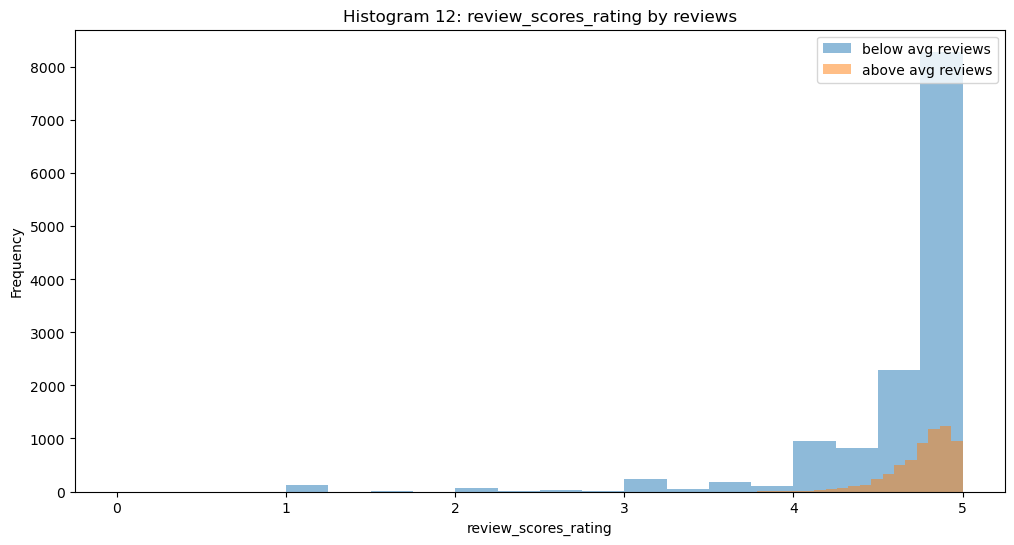

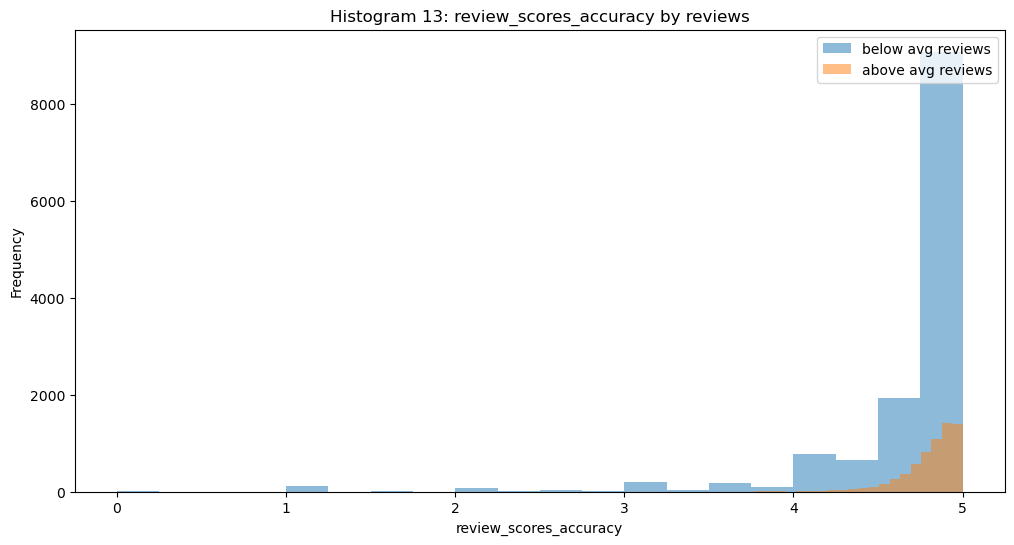

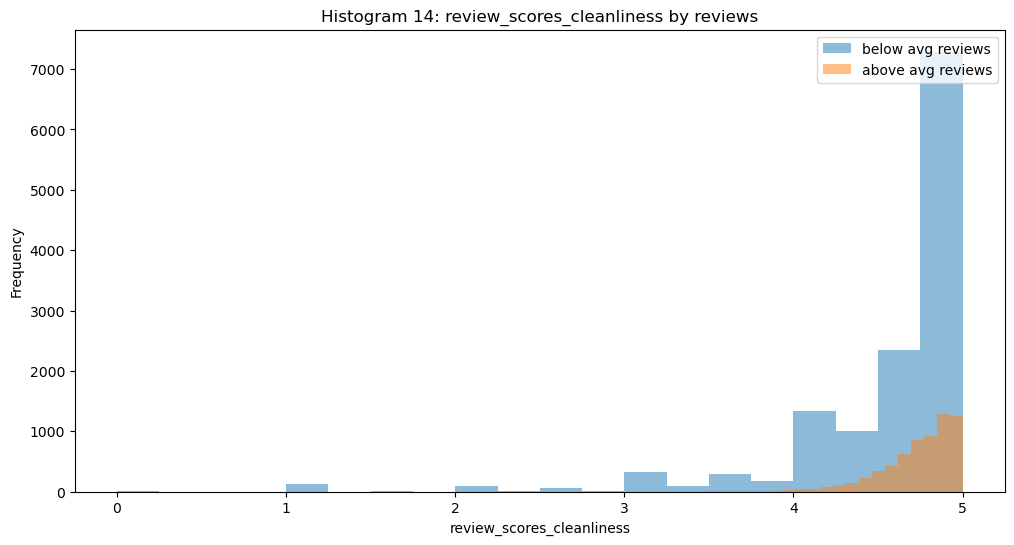

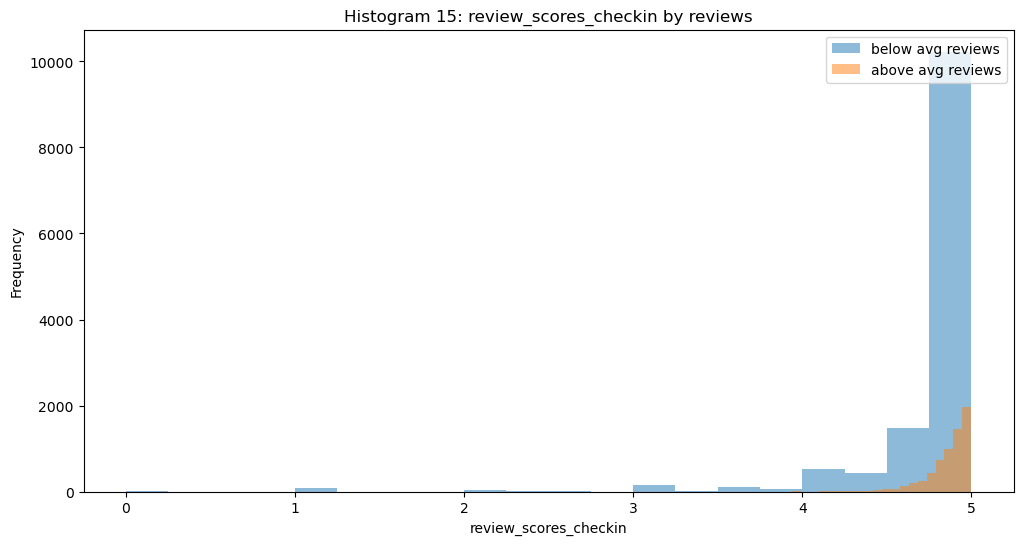

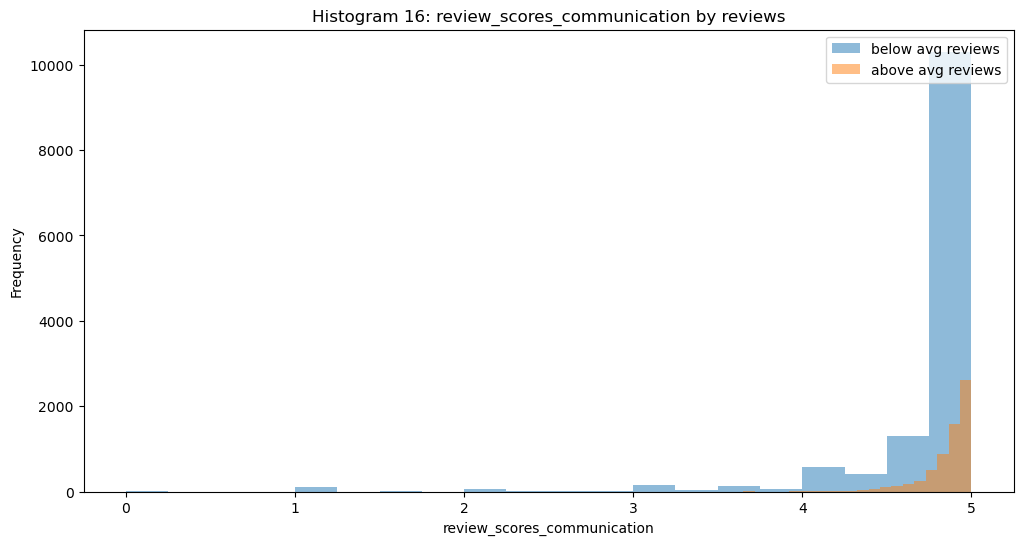

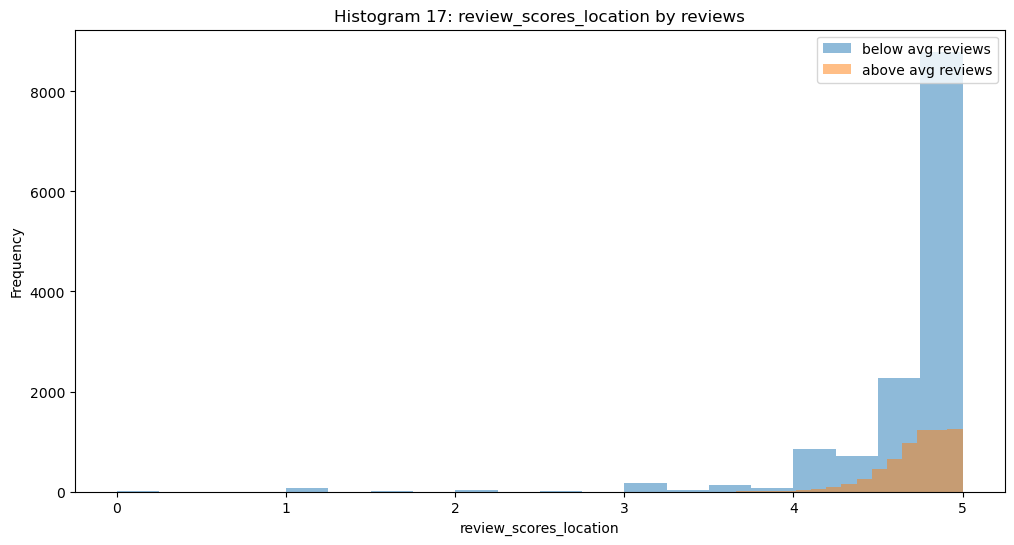

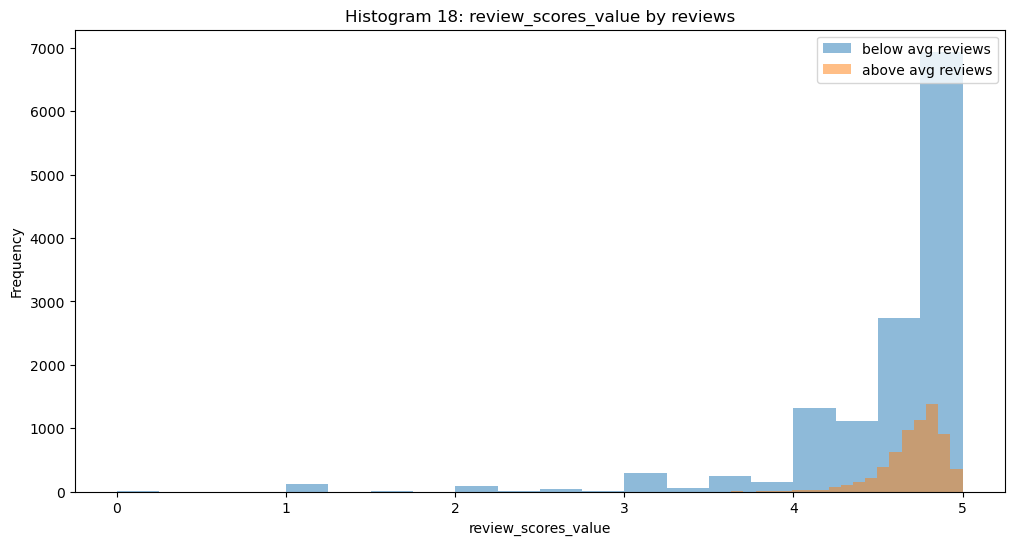

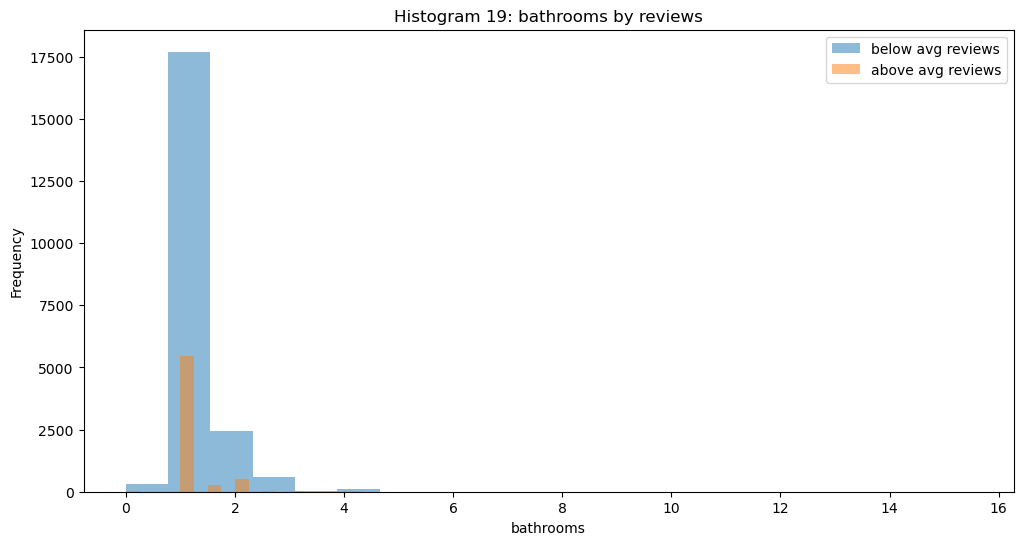

In [11]:
# creating new dataframes by below or above average number of reviews
below_avg_reviews = train_df[train_df["number_of_reviews"] < 25]
above_avg_reviews = train_df[train_df["number_of_reviews"] > 25]

# identifying numeric columns to use for histograms
numeric_cols = train_df.select_dtypes(include=['int', 'float']).columns.tolist()

# removing id from numeric_cols as that is unique per listing
numeric_cols.remove('id')

# removing host_id from numeric_cols as that cannot be generalized
numeric_cols.remove('host_id')

# removing reviews_per_month from numeric_cols as that is the target feature
numeric_cols.remove('reviews_per_month')


# # visualizing features in numeric_cols 
# initializing counter variable
counter = 1

for feature in numeric_cols:
    plt.figure(figsize = (12, 6))
    plt.hist(below_avg_reviews[feature], bins = 20, alpha = 0.5, label = "below avg reviews")
    plt.hist(above_avg_reviews[feature], bins = 20, alpha = 0.5, label = "above avg reviews")
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.title(f'Histogram {counter}: {feature} by reviews')
    plt.show()
    
    # incrementing counter
    counter += 1


The histogram of price is not very insightful as the distribution of the below avg reviews and above average reviews price is not very clear. Let's adjust the x scale to see if it makes the histogram more clear. 

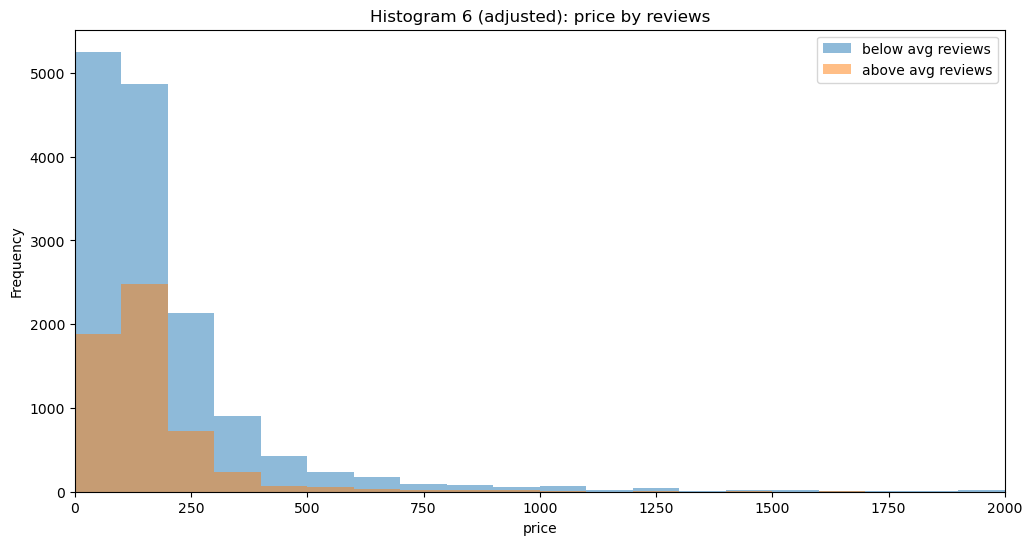

In [12]:
plt.figure(figsize=(12, 6))
plt.hist(below_avg_reviews['price'], bins=20, alpha=0.5, label="below avg reviews", range=(0, 2000))
plt.hist(above_avg_reviews['price'], bins=20, alpha=0.5, label="above avg reviews", range=(0, 2000))
plt.xlabel('price')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Histogram 6 (adjusted): price by reviews')
plt.xlim(0, 2000)  # This sets the x-axis to show only from 0 to 2000
plt.show()

From this histogram, it does not seem like there is a major distinction between the price of an Airbnb listing and the number of reviews. 
* Most listings, both below and above average number of reviews, are concentrated in the lower price range, suggesting that more affordable listings are common. There is a rapid decline in frequency as the prices increase, suggesting that higher-priced listings are less common.
* It seems that the price of a listing is not a strong indicator of its reviews since both categories follow a similar distribution.

### Observations of notable numerical features

At this stage, there are no significant distinctions between features when separated by above or below the average number_of_reviews. However, some notable observations are:
* **Histogram 2**: hosts with less listings tend to have above the average number of reviews
* **Histogram 8**: listings with lower minimum_nights tend to have above average number of reviews
* **Histogram 12 - 18**: on average there is a much larger number of listings with below average number of reviews than above average number of reviews, regardless of the review type.

## Categorical Variables

In [13]:
# identifying categorical columns to use for histograms
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()
categorical_cols

['name',
 'neighborhood_overview',
 'host_is_superhost',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'property_type',
 'room_type',
 'instant_bookable']

From this list, let us visualize the features:
* neighbourhood_group_cleansed
* room_type

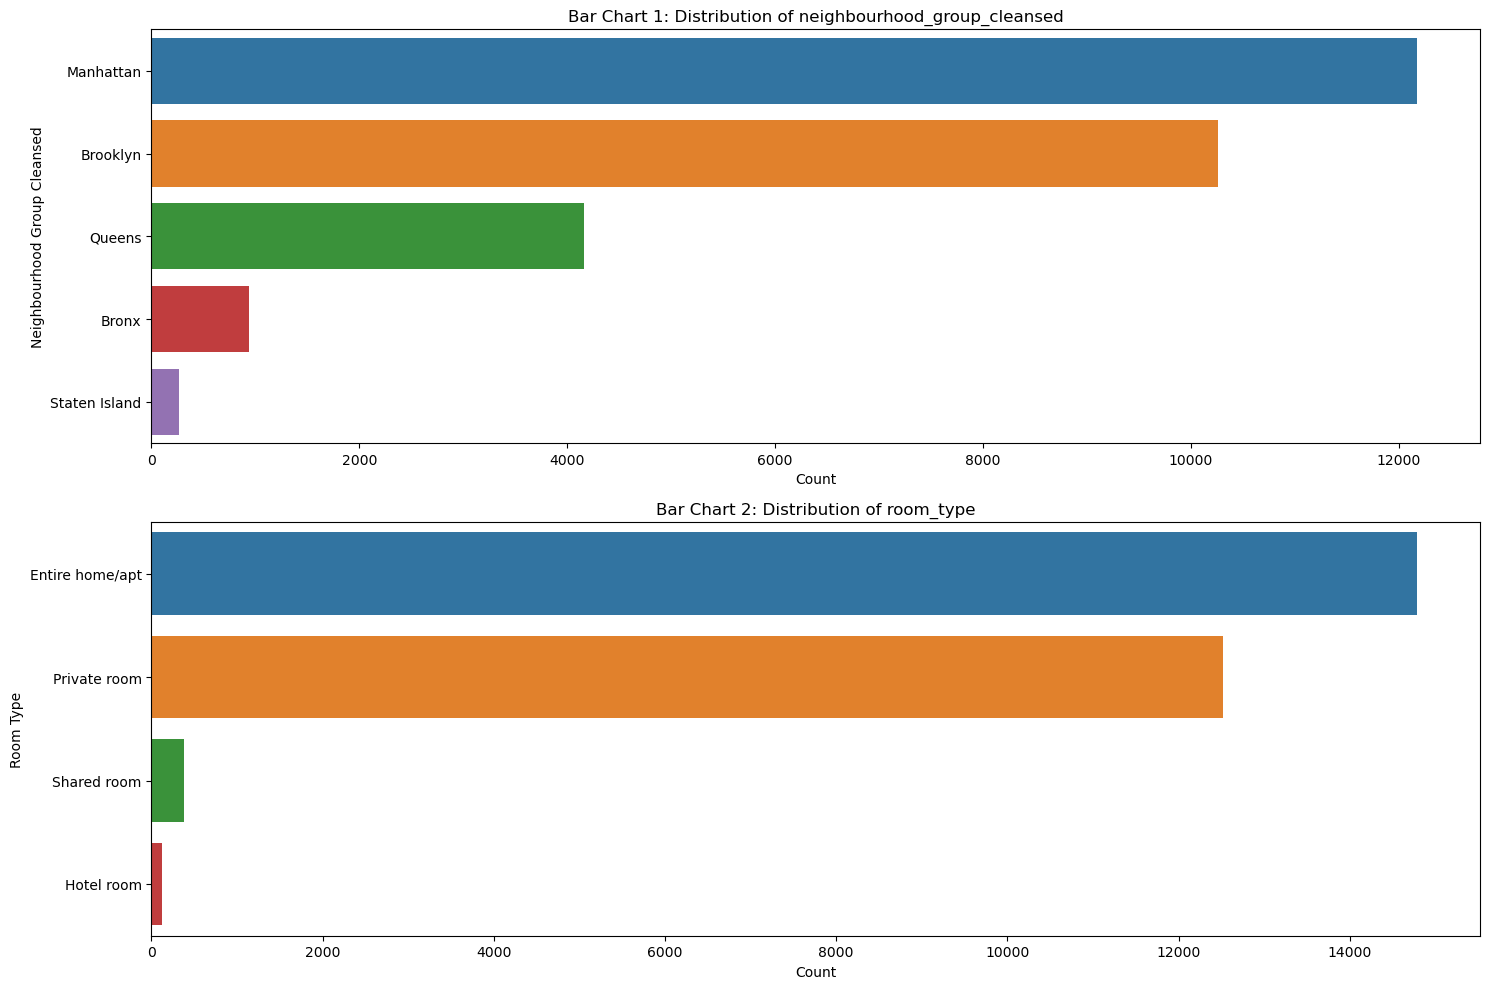

In [14]:
# defining list of selected categorical columns for visualization
categorical_viz_cols = ['neighbourhood_group_cleansed', 'room_type']

# plotting visualizations

# initializaing no.
no = 1

plt.figure(figsize=(15, 5 * len(categorical_viz_cols)))
for i, col in enumerate(categorical_viz_cols, 1):
    plt.subplot(len(categorical_viz_cols), 1, i)
    sns.countplot(y=train_df[col], order = train_df[col].value_counts().index)
    plt.title(f'Bar Chart {no}: Distribution of {col}')
    plt.xlabel('Count')
    plt.ylabel(col.replace('_', ' ').title())

    #updating no
    no += 1

plt.tight_layout()
plt.show()



### Observations of Visualized Categorical Features

* **Bar Chart 1**: Manhattan and Brooklyn are the most popular neighbourhood groups
* **Bar Chart 2**: The most popular room_type listings are 'Entire home/apt' and 'Private room'

#### Interactive Map To Visualize Geographical Spread of Listings

In [15]:
lats = train_df['latitude'].tolist()
longs = train_df['longitude'].tolist()

locations = list(zip(lats, longs))

map1 = folium.Map(location=[40.6899,-73.8744], zoom_start=9.5)
FastMarkerCluster(data=locations).add_to(map1)
map1


### Feature Engineering

Extracting new features relevant to the problem.

<u>Feature 1: Distance to Times Square</u>
With over [50 million visitors annually](https://artsandculture.google.com/entity/times-square/m07qdr?hl=en), Times Square is the most visited tourist attraction in New York City. Given that we have longitude and latitude, a useful feature for investigating the popularity of a listing could be distance to Times Square. To do this, a new feature, 'dist_to_ts' representing the Euclidean distance between a listing and Times Square will be created.

<u>Feature 2: Price per Bed</u>

Another potentially useful feature is the Price of the listing per beds listed. From EDA, it was observed that in general there were more listings at a lower price. Breaking down the price component per number of beds could offer a more specific understanding of the value and how that might affect the popularity of a listing. The feature, 'price_per_bed' will be created by dividing the listing price, 'price', by the number of beds, 'beds'.



In [16]:
#creating feature 1

# defining the coordinates of Times Square
ts_longitude = -73.985130
ts_latitude = 40.758896

# function for calculating the Euclidean distance
def euclidean_distance(lon1, lat1, lon2, lat2):
    return np.sqrt((lon1 - lon2)**2 + (lat1 - lat2)**2)

# creating 'dist_to_ts' feature
train_df['dist_to_ts'] = train_df.apply(lambda row: euclidean_distance(row['longitude'], row['latitude'], ts_longitude, ts_latitude), axis=1)

train_df['dist_to_ts'].head()

7481     0.010472
13704    0.035219
37758    0.111680
38153    0.156291
39473    0.009988
Name: dist_to_ts, dtype: float64

In [17]:
# creating feature 2

# Create the 'price_per_bed' feature
train_df['price_per_bed'] = train_df['price'] / train_df['beds']

train_df['price_per_bed'].head()

7481     148.0
13704     65.0
37758    120.0
38153     68.0
39473    314.0
Name: price_per_bed, dtype: float64

### Visualizing New Features

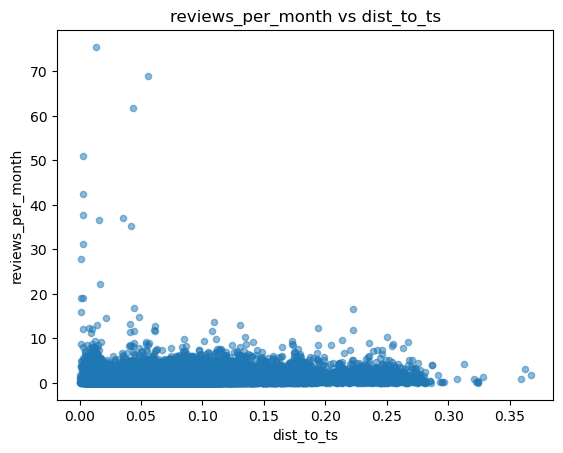

In [18]:
new_features = ['dist_to_ts', 'price_per_bed']

# # visualizing features in numeric_cols 

# plotting 'dist_to_ts' 
train_df.plot.scatter('dist_to_ts', 'reviews_per_month', alpha = 0.5)
plt.title('reviews_per_month vs dist_to_ts')
plt.ylabel('reviews_per_month')
plt.plot()
plt.show()

This plot shows that while the majority of listings' popularity is not determined by the distance to Times Square, select listings closer to Times Square have a much higher reviews_per_month. Listings with the greatest distance to Times Square have very low reviews_per_month.

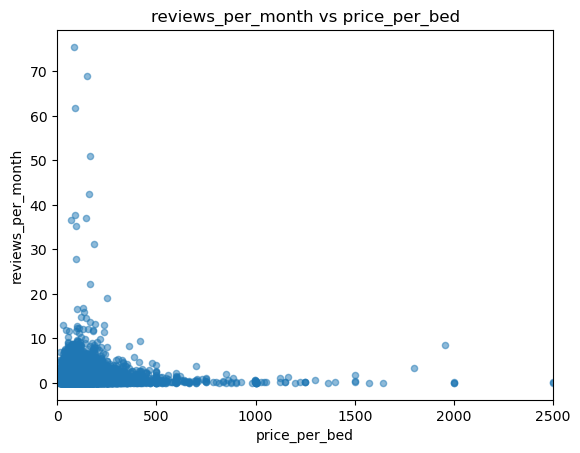

In [19]:
# plotting 'price_per_bed' 
train_df.plot.scatter('price_per_bed', 'reviews_per_month', alpha = 0.5)
plt.title('reviews_per_month vs price_per_bed')
plt.ylabel('reviews_per_month')
plt.xlim(0, 2500) # axis was adjusted to focus on range with the greater point density
plt.plot()
plt.show()

This plot shows that the majority of listings are in the lower price_per_bed range. The listings with a lower price_per_bed value tend to have a higher reviews_per_month value.

# Preprocessing and Transformations

Before any transformations are applied, there were a few alterations applied during the EDA. These be applied to both the training and test set:
* drop the '$' in the feature, 'price'
* extract the number for the feature, 'bathrooms_text', to create feature 'bathrooms'
* remove the % in the feature, 'host_acceptance_rate'
* add the newly created features: 'dist_to_ts' and 'price_per_bed'

In [20]:
# Dropping the '$' in the feature, 'price'

test_df['price'] = test_df['price'].str.replace('[\$,]', '', regex=True).astype(float)

test_df['price'].head()

4231      89.0
22626    150.0
32861    200.0
21327     88.0
19536    101.0
Name: price, dtype: float64

In [21]:
# extracting the number for the feature, 'bathrooms_text'

test_df['bathrooms'] = test_df['bathrooms_text'].apply(extract_no)
test_df.drop('bathrooms_text', axis =1, inplace = True)

test_df['bathrooms'].head()

4231     1.0
22626    1.0
32861    1.0
21327    1.0
19536    1.0
Name: bathrooms, dtype: float64

In [22]:
# removing the '%' in the feature, 'host_acceptance_rate'

test_df['host_acceptance_rate'] = test_df['host_acceptance_rate'].str.replace('%', '').astype(float).fillna(0).astype(int)

test_df['host_acceptance_rate'].head()

4231      51
22626     87
32861    100
21327     90
19536     69
Name: host_acceptance_rate, dtype: int32

In [23]:
# adding feature 'dist_to_ts'

test_df['dist_to_ts'] = test_df.apply(lambda row: euclidean_distance(row['longitude'], row['latitude'], ts_longitude, ts_latitude), axis=1)
test_df['dist_to_ts'].head()

4231     0.016234
22626    0.118661
32861    0.007374
21327    0.003113
19536    0.042681
Name: dist_to_ts, dtype: float64

In [24]:
# adding feature 'price_per_bed'
test_df['price_per_bed'] = test_df['price'] / test_df['beds']

test_df['price_per_bed'].head()

4231      89.0
22626     75.0
32861    100.0
21327     88.0
19536     50.5
Name: price_per_bed, dtype: float64

Applying changes to the train and test sets is generally not good practice, as there is a high chance that different changes are applied. Here are some tests to ensure that both the test and the train sets have the same variables. The test covers that both sets have the same features, and dtypes.

In [25]:
# matching tests

if train_df.columns.tolist() == test_df.columns.tolist() and train_df.dtypes.equals(test_df.dtypes):
    print("Both DataFrames have the same column titles (features) and data types.")
else:
    print("DataFrames have different column titles or data types.")

Both DataFrames have the same column titles (features) and data types.


Test passed! We can move on to applying transformations.

### Transformations Summary

|feature type | features | transformations |
|-------------|----------------|-------------|
|numeric feature | host_acceptance_rate, host_total_listings_count, latitude, longitude, accomodates, beds, price, minimum_nights, maximum_nights, availability_365, review_scores_rating, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location, review_scores_value, bathrooms, dist_to_ts, price_per_bed | standard scaling, simple imputer with strategy = 'mean' |
| categorical feature | neighborhood_overview, neighbourhood_cleansed, neighbourhood_group_cleansed, property_type, room_type | one hot encoding, simple imputer with strategy = "most_frequent" |
| binary features | host_is_superhost ,instant_bookable | one hot encoding with drop = 'if_binary', simple imputer with strategy = "most_frequent" |
| drop features | id, name, host_id, number_of_reviews| drop, not ideal for generalizable learning. number_of_reviews is dropped because it is *very* correlated to the target feature|
| target | reviews_per_month| target feature|



In [26]:
# setting up different feature groups

numeric_features = ['host_acceptance_rate', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'beds', 'price', 
                    'minimum_nights', 'maximum_nights', 'availability_365', 'review_scores_rating', 'review_scores_accuracy', 
                    'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
                    'review_scores_value', 'bathrooms', 'dist_to_ts', 'price_per_bed']

categorical_features = ['neighborhood_overview', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'property_type', 'room_type']

binary_features = ['host_is_superhost', 'instant_bookable']

drop_features = ['id', 'name', 'host_id', 'number_of_reviews']

target = 'reviews_per_month'


In [27]:
# defining transformers

numeric_pipeline = make_pipeline(SimpleImputer(strategy = "mean"), 
                                 StandardScaler())

categorical_pipeline = make_pipeline(SimpleImputer(strategy = "most_frequent"), 
                                     OneHotEncoder(handle_unknown='ignore'))

binary_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(drop='if_binary', handle_unknown='ignore')
)

preprocessor = make_column_transformer(
    (numeric_pipeline, numeric_features),
    (categorical_pipeline, categorical_features),
    (binary_pipeline, binary_features), 
    ("drop", drop_features)
)
                                     

In [28]:
# changing NaN rows in target column to 0

train_df[target] = train_df[target].fillna(0)
test_df[target] = test_df[target].fillna(0)


train_df[target]

7481     0.15
13704    0.00
37758    0.56
38153    0.00
39473    0.40
         ... 
7763     0.57
15377    0.45
17730    1.39
28030    0.61
15725    0.00
Name: reviews_per_month, Length: 27803, dtype: float64

### Baseline Model

Applying scikit-learn's baseline model to the training set to later compare to the  other models.

In [29]:
# dropping the target feature from the X sets and creating y sets

X_train = train_df.drop(target, axis=1)

y_train = train_df[target]

X_test = test_df.drop(target, axis = 1)

y_test = test_df[target]


In [30]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores.iloc[i], std_scores.iloc[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [31]:
# creating a dictionary to store the cross validation results for different models

results_dict = {}

# defining dummy model
dummy = DummyRegressor()

# defining dummy model pipeline with preprocessor
pipe = make_pipeline(preprocessor, dummy)

# adding cross validation score summary to results data frame
results_dict["dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, cv=10, return_train_score=True
)

results_df = pd.DataFrame(results_dict).T
results_df

,fit_time,score_time,test_score,train_score
dummy,0.014 (+/- 0.005),0.002 (+/- 0.000),-0.000 (+/- 0.000),0.000 (+/- 0.000)


The test_score is negative (not purely 0, it is just really small so it is cut off), indicating that the dummy model has essentially no advantage in prediction accuracy.

# Linear Model: Ridge Regression

Attempting various linear models and conducting hyperparameter turning to explore different values for model complexity. Each model's cross-validation and standard deviation score will be reported.

### Ridge

In [32]:
# Using sklearn Ridge()
ridge = Ridge(random_state = 123)

# defining ridge pipeline with preprocessor 
pipe_ridge = make_pipeline(preprocessor, ridge)

# adding cross validation score summary to results data frame
results_dict["Ridge Default"] = mean_std_cross_val_scores(pipe_ridge, X_train, y_train, cv=10, return_train_score=True)
results_df = pd.DataFrame(results_dict).T

In [33]:
results_df

,fit_time,score_time,test_score,train_score
dummy,0.014 (+/- 0.005),0.002 (+/- 0.000),-0.000 (+/- 0.000),0.000 (+/- 0.000)
Ridge Default,1.570 (+/- 0.073),0.079 (+/- 0.005),-6.430 (+/- 21.118),0.556 (+/- 0.019)


Ridge with the default hyperparameter settings performs poorly. Let us investigate if performance is improved after hyperparameter tuning.

In [34]:
# preprocessor.fit_transform(X_train)

In [35]:
# hyperparameter tuning

# defining a dictionary with alpha models we want to test
alpha_vals = {"alpha": 10.0 ** np.arange(-3, 6, 1)}

# computing cross validation score summary for each value of alpha and storing it in results dictionary
for a in alpha_vals["alpha"]:
    pipe_ridge = make_pipeline(preprocessor, Ridge(alpha=a))
    results_dict["Ridge, alpha= " + str(a)] = mean_std_cross_val_scores(pipe_ridge, X_train, y_train, return_train_score=True)

results_df = pd.DataFrame(results_dict).T
results_df

,fit_time,score_time,test_score,train_score
dummy,0.014 (+/- 0.005),0.002 (+/- 0.000),-0.000 (+/- 0.000),0.000 (+/- 0.000)
Ridge Default,1.570 (+/- 0.073),0.079 (+/- 0.005),-6.430 (+/- 21.118),0.556 (+/- 0.019)
"Ridge, alpha= 0.001",2.773 (+/- 0.422),0.102 (+/- 0.025),-3.218 (+/- 7.652),0.660 (+/- 0.039)
"Ridge, alpha= 0.01",2.265 (+/- 0.303),0.070 (+/- 0.003),-3.196 (+/- 7.614),0.659 (+/- 0.039)
"Ridge, alpha= 0.1",1.838 (+/- 0.136),0.069 (+/- 0.002),-3.833 (+/- 9.072),0.655 (+/- 0.038)
"Ridge, alpha= 1.0",1.032 (+/- 0.014),0.066 (+/- 0.002),-7.560 (+/- 17.464),0.558 (+/- 0.028)
"Ridge, alpha= 10.0",0.620 (+/- 0.024),0.071 (+/- 0.003),-16.133 (+/- 36.607),0.308 (+/- 0.012)
"Ridge, alpha= 100.0",0.416 (+/- 0.005),0.068 (+/- 0.004),-25.527 (+/- 57.562),0.211 (+/- 0.013)
"Ridge, alpha= 1000.0",0.335 (+/- 0.006),0.072 (+/- 0.004),-40.484 (+/- 90.973),0.183 (+/- 0.013)
"Ridge, alpha= 10000.0",0.297 (+/- 0.004),0.070 (+/- 0.002),-63.010 (+/- 141.266),0.152 (+/- 0.011)


While a Ridge Model with alpha = 0.001 performs slightly better than the baseline model, the difference between test_score and train_score is quite high with the standard deviation for the test_score being quite high. This suggests that the Ridge models do not generalize well on unseen data, and perhaps Ridge is not an appropriate model, given this data.

# Ensemble Models

Given that the data might not be suitable for a linear regression, we will try ensemble models. Ensemble models have the advantage of combining multiple machine learning models to create a more powerful model. An ensemble of several smaller models allows for better learning for capturing non-linear relationships with less overfitting. 

In [36]:
# creating a separate dictionary for the cross validation results of ensemble models
ensemble_results = {}

### Random Forest Regressor

Random Forest Regressors employ a collection of decision trees, where each tree overfits on some aspect of the data and the results are averaged. Furthermore, Random Forest regressors introduce randomness from both data (creates a collection of trees where each tree is grown on an independent bootstrap sample of the data) and features (for each tree, randomly select a subset of features out of all features, find the best split on the selected features, grow the trees to max depth). This makes it less prone to overfitting, so the gap between the train scores and test scores might be better than that of the Ridge models.

In [37]:
pipe_randomfr = make_pipeline(preprocessor, RandomForestRegressor(max_depth = 10, n_jobs =-1, random_state = 123))

ensemble_results["Random Forest Regressor"] = mean_std_cross_val_scores(pipe_randomfr, X_train, y_train, cv=10, return_train_score=True)

pd.DataFrame(ensemble_results).T

,fit_time,score_time,test_score,train_score
Random Forest Regressor,19.336 (+/- 0.513),0.113 (+/- 0.010),0.411 (+/- 0.144),0.717 (+/- 0.007)


Compared to Ridge Regression, the Random Forest model performs much better. 

**Comments**: 
* There is a considerable drop from the train score and the test score.
* The standard deviation for the test score is also much higher than the standard deviation of the train_score.
* The points above suggests that the Random Forest regressor generalizes poorly on new data. 
* The fit time for the Random Forest model is much higher than that of the Ridge Regression models. This is a tradeoff between time cost and performance, and is computationally more expensive.

### Gradient Boosting Regressor

Gradient-boosted trees are composed of several shallow trees built sequentially. Each tree takes the errors of the previous tree to improve overall peformance. Unlike Random Forest Regressors, Gradient Boosted trees do not introduce randomness.

In [38]:
pipe_gbr = make_pipeline(preprocessor, GradientBoostingRegressor(random_state=123))

ensemble_results["Gradient Boosting Regressor"] = mean_std_cross_val_scores(pipe_gbr, X_train, y_train, cv=10, return_train_score=True)

pd.DataFrame(ensemble_results).T

,fit_time,score_time,test_score,train_score
Random Forest Regressor,19.336 (+/- 0.513),0.113 (+/- 0.010),0.411 (+/- 0.144),0.717 (+/- 0.007)
Gradient Boosting Regressor,30.049 (+/- 0.297),0.064 (+/- 0.002),0.397 (+/- 0.123),0.679 (+/- 0.013)


Gradient Boosting Regressor performs roughly the same as the Random Forest Regressor. While the mean train and test scores seem to be slightly lower than the Random Forest Regressor, the difference is not significant due to the standard deviation. 

**Comments**:
* The fit time of the Gradient Boosting Regressor is slightly than the Random Forest Regressor, however due to the large standard deviations for both models' fit times, we cannot claim one is significanlty better than the other.
* The difference between the test_score and the train_score is quite large, suggesting that the Gradient Boosting Regressor generalizes poorly to unseen data.


#### Selected Model: Random Forest Regressor
Out of the different models tested, we will move forward with Random Forest Regressor. 

**Reasoning**:
* Overall test_score is higher than that of Gradient Boosting Regressor
    * Note: due to the standard deviations in the test_score, we cannot claim that Random Forest Regressor is significantly better than Gradient Boosting Regressor. The decision to go with the Random Forest is due to the higher mean train_score.
* Both models have a significant gap between the train and test scores. However, Random Forest introduces randomness from two sources as discussed before, so there is a better chance that it may overfit less than Gradient Boosting Regressor.
* While Random Forest Regressor has a slightly higher fit_time and score_time than Gradient Boosting Regressor, due to the large standard deviations, we cannot confidently say it is computationally more expensive than Gradient Boosting Regressor.

# Hyperparameter Optimization

Given that we have chosen to continue with RandomForestRegressor, this section will attempt to optimize some of the model's hyperparamers:
* <u> n_estimators </u>: the number of trees in the forest
* <u> max_features </u>: the number of features to consider when looking for the best split
    * this will be used for feature selection
* <u> max_depth </u>: the maximum depth of the tree

The method used is **randomized hyperparameter search**, which samples configurations at random until the search budget is exhausted. The reason why this method is selected is because it is faster than exhaustive search methods such as GridSearch. Moreover, its performance is not significantly affected by irrelevant parameters so it works particularly well when some parameters are more important than others in the set.

In [39]:
# defining parameter grid for the hyperparameters n_estimators, max_features, and max_depth
param_grid = {
    "randomforestregressor__n_estimators": [1, 5, 10, 15],
    "randomforestregressor__max_features": [5, 10, 25, 50],
    "randomforestregressor__max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
            
}

# defining randomized search object
random_search = RandomizedSearchCV(pipe_randomfr,                                    
                  param_distributions = param_grid, 
                  n_iter=100, 
                  n_jobs=-1, 
                  return_train_score=True)

# fitting random_search on the training datasets
random_search.fit(X_train, y_train)


pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        "param_randomforestregressor__n_estimators",
        "param_randomforestregressor__max_features",
        "param_randomforestregressor__max_depth",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

rank_test_score,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
mean_test_score,0.351904,0.349323,0.34258,0.340192,0.328217,0.327994,0.322347,0.313164,0.310975,0.302137,...,0.001025,0.000037,-0.000944,-0.002162,-0.060375,-0.106812,-0.205827,-0.218913,-0.264857,-0.351071
param_randomforestregressor__n_estimators,15,15,15,15,10,15,15,15,10,10,...,1,1,5,1,1,1,1,1,1,1
param_randomforestregressor__max_features,50,50,25,50,50,50,50,25,25,25,...,10,5,5,10,25,50,50,50,50,50
param_randomforestregressor__max_depth,90,100,100,80,90,70,60,90,80,90,...,10,10,20,20,90,40,60,70,90,80
mean_fit_time,48.075681,42.690844,25.565231,36.156551,26.77577,32.011257,43.764467,34.301211,26.242731,26.692714,...,2.578966,4.016227,0.913189,1.085293,21.268024,1.822944,3.582055,12.838146,7.239674,29.219859


From these results, the best performing (according to test_score) is a Random Forest Regressor with n_estimators = 15, max_features = 50, and max_depth = 90. It is important to note that this also had a significanlty high mean_fit_time. For the sake of this project's objective, we will proceed with this combination to maximize the performance on the test set. It is important to note that randomized hyperparameter search does not guarantee finding the optimal hyperparameter values.

In [40]:
# defining optimized Random Forest Regressor Model

rf_model = RandomForestRegressor(n_estimators = 15, max_features = 50, max_depth = 10, n_jobs = -1, random_state=123)


# Feature Importance and Selection

Feature selection offers the following benefit:
* <u> interpretability: </u> models are more interpretable with fewer features
* <u> computation: </u> models fit/predict faster with fewer features
* <u> overfitting: </u> by getting rid of features that are not important, we can reduce the chance of overfitting

Given the results from the previous section, we will continue with feature selection for the optimal Random Forest Regressor model.

In [41]:
selector_rf = SelectFromModel(rf_model, threshold='median', max_features = 50)

pipe_rf_model_based = make_pipeline(preprocessor, selector_rf, rf_model)

pd.DataFrame(
    cross_validate(pipe_rf_model_based, X_train, y_train, return_train_score=True)
).mean()

fit_time       3.366050
score_time     0.208788
test_score     0.353981
train_score    0.738790
dtype: float64

In [42]:
# obtaining the list of features

# Fit the pipeline
pipe_rf_model_based.fit(X_train, y_train)

# Get the model used inside the SelectFromModel step
selector_model = pipe_rf_model_based.named_steps['selectfrommodel'].estimator_

# Retrieve the feature importances from this model
selector_importances = selector_model.feature_importances_

# Get the transformed feature names
transformed_features = preprocessor.transform(X_train)
transformed_feature_names = preprocessor.get_feature_names_out()

# Apply the selection logic to get the selected feature names and importances
selected_features_mask = pipe_rf_model_based.named_steps['selectfrommodel'].get_support()
selected_features = transformed_feature_names[selected_features_mask]
selected_importances = selector_importances[selected_features_mask]

# Create a DataFrame for the feature importances
feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': selected_importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Display the feature importance DataFrame
print(feature_importance_df)


                                              Feature  Importance
0   pipeline-2__neighborhood_overview_Located in t...    0.113874
1                        pipeline-1__availability_365    0.092871
2                   pipeline-1__review_scores_checkin    0.082560
3   pipeline-2__neighborhood_overview_Our building...    0.060600
4                    pipeline-1__review_scores_rating    0.059509
5                          pipeline-1__maximum_nights    0.051332
6                                   pipeline-1__price    0.051327
7             pipeline-1__review_scores_communication    0.043935
8                               pipeline-1__longitude    0.041812
9   pipeline-2__neighborhood_overview_Times Square...    0.027545
10  pipeline-2__property_type_Private room in bed ...    0.023974
11  pipeline-2__property_type_Private room in gues...    0.021964
12                    pipeline-1__review_scores_value    0.021230
13                     pipeline-3__instant_bookable_t    0.019815
14  pipeli

**Comments**: 

The list is not very interpretable due to the one hot encoding in the preprocessing step. While we have an original set of features, this table is organized by subcategorization of the features. Here is a summary (in order of appearance, not listing repetitions) of the pre-preprocessing features that appear on this list:
* neighbourhood_overview
* availability_365
* review_scores_checkin
* review_scores_rating
* maximum_nights
* price
* communication
* longitude
* property_type
* review_scores_value
* instant_bookable
* host_is_superhost
* review_scores_accuracy
* review_scores_cleanliness
* review_scores_location
* price_per_bed
* room_type
* neighbourhood_group_cleansed

## Training Model Summary

**Best Model**: Random Forest Regressor, with:
* n_estimators = 15
* max_features = 50
* max_depth = 10

**Most Important Features Contributing to Target: reviews_per_month**:

1. neighbourhood_overview
2. availability_365
3. review_scores_checkin
4. review_scores_rating
5. maximum_nights
6. price
7. review_scores_communication
8. longitude
9. property_type
10. review_scores_value
11. instant_bookable
12. host_is_superhost
13. review_scores_accuracy
14. review_scores_cleanliness
15. review_scores_location
16. price_per_bed
17. room_type
18. neighbourhood_group_cleansed

# Results on Test Set

The best performing model will now be applied to the test set.

In [43]:
# defining features groups
final_drop = [
    'id',
    'name',
    'host_id',
    'host_acceptance_rate',
    'host_total_listings_count',
    'neighbourhood_cleansed',
    'latitude',
    'accommodates',
    'beds',
    'minimum_nights',
    'number_of_reviews',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_communication',
    'review_scores_location',
    'bathrooms',
    'dist_to_ts'
]

final_numeric_features = ['availability_365', 'review_scores_checkin', 'review_scores_rating', 'maximum_nights',
                   'price', 'review_scores_communication', 'longitude', 'review_scores_value', 'review_scores_accuracy',
                   'review_scores_cleanliness', 'review_scores_location', 'price_per_bed']

final_categorical_features = ['neighborhood_overview', 'neighbourhood_group_cleansed', 'property_type', 'room_type']

final_binary_features = ['host_is_superhost', 'instant_bookable']

final_target = 'reviews_per_month'


In [44]:
# defining pipelines and columntransformer

final_numeric_pipeline = make_pipeline(SimpleImputer(strategy = "mean"), 
                                 StandardScaler())

final_categorical_pipeline = make_pipeline(SimpleImputer(strategy = "most_frequent"), 
                                     OneHotEncoder(handle_unknown='ignore'))

final_binary_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(drop='if_binary', handle_unknown='ignore')
)

final_preprocessor = make_column_transformer(
    (final_numeric_pipeline, final_numeric_features),
    (final_categorical_pipeline, final_categorical_features),
    (final_binary_pipeline, final_binary_features), 
    ("drop", final_drop)
)



             

In [45]:
# defining final pipeline
final_rf_pipeline = make_pipeline(final_preprocessor, rf_model)

# fitting the pipeline on the train set
final_rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['availability_365',
                                                   'review_scores_checkin',
                                                   'review_scores_rating',
                                                   'maximum_nights', 'price',
                                                   'review_scores_communication',
                                                   'longitude',
                                                   'review_scores_value',
                                                   'review_scores_accuracy...
                                                   'neighbourhood_cleansed',
                                                   'latitude', 'accommodates',
                                                   'beds', 'minimum_nights',
                                                   'number_of_reviews',
                                                   'review_scores_accuracy',
                                                   'review_scores_cleanliness',
                                                   'review_scores_communication',
                                                   'review_scores_location',
                                                   'bathrooms',
                                                   'dist_to_ts'])])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=10, max_features=50,
                                       n_estimators=15, n_jobs=-1,
                                       random_state=123))])

In [46]:
# obtaining test scores

final_rf_pipeline.score(X_test, y_test)

0.056079244540955475

### Final Score: 0.056079244540955475

# Conclusion

The performance of the final model on the test set is *very* low, at 0.056. Despite the efforts made, here are some reasons for the poor performance:
* **data preprocessing**: this project took on quite a simple approach to the preprocessing stage, sorting the features to numerical, categorical, binary, and drop features. Some improvements could be:
    * Identifying if any of the ordinal features were ordinal
    * Applying regularization methods to the numerical features
    * Before any training, a list of features were dropped. These features could have been potentially useful and in another attempt they could be kept and removed accordingly during the feature selection stage
* **feature engineering**: despite the attempts to make new features, this stage could be much more effective after consulting a domain expert. In isolation, certain features may seem insignificant but prove very important when combined with other features.
* **Model Selection**: only three models were chosen before committing to Random Forest Regressor. There is a chance that the data was perhaps not the most appropriate for this model. Furthermore, other ensemble models such sklearn's HistGradientBoostingRegressor could have been tested.
* **Hyperparameter Optimization**: at this stage, Randomized Search was employed, which does not guarantee finding the optimal hyperparameter values as it is not exhaustive in its search. Alternatively, GridSearchCV could be applied. GridSearch allows users to define a parameter grid, which it then exhaustively searches. This could yield better results as it conducts a thorough search of every combination defined in the parameter grid.
* **Feature importance and selection**: for these stages, model-based selection was employed. Future attempts could try out other methods such as Recursive Feature Elimination using sklearn's RFE, RFECV (employs cross validation) or sklearn Sequential Feature Selection methods such as forward and backward selection.
* **Data Leakage**: although I tried my best to avoid data leakage by organizing the preprocessing and models through pipelines, there is still a chance that models were exposed to data from the test set during training. This could account for inflated train scores and test scores that are significantly lower as a result of overfitting.